# フィッティングと最適化-optimize

SciPyの`optimize`モジュールは、非線形方程式の求解、データフィッティング、関数の最小値探索など、多くの数値最適化アルゴリズムを提供しています。本節では、その中の非線形方程式の求解、データフィッティング、関数の最小値探索などについて簡単に紹介します。

In [1]:
from matplotlib import pyplot as plt
import helper.matplotlib
import numpy as np
from scipy import optimize

## 非線形方程式の求解

`fsolve()`は非線形方程式を解くための関数で、基本的な呼び出し形式は`fsolve(func, x0)`です。ここで、`func`は方程式の誤差を計算する関数で、そのパラメータ`x`は方程式の解の候補となる配列です。`func`は`x`を方程式に代入した後の各方程式の誤差を返し、`x0`は未知数の初期値です。以下の方程式を解く場合を考えます：

$$
\begin{align}
f1(u1,u2,u3) &= 0 \\ 
f2(u1,u2,u3) &= 0 \\ 
f3(u1,u2,u3) &= 0
\end{align}
$$
    
この場合、`func`関数は以下のように定義できます：

```python
def func(x):
    u1,u2,u3 = x
    return [f1(u1,u2,u3), f2(u1,u2,u3), f3(u1,u2,u3)]
```

以下は、以下の方程式を解く例です：

$$
\begin{align}
5 x_1 + 3 &= 0 \\ 
4 x_0^2 - 2 \sin(x_1 x_2) &= 0 \\ 
x_1 x_2 - 1.5 &= 0
\end{align}
$$

In [2]:
from math import sin, cos
from scipy import optimize


def f(x):  #❶
    x0, x1, x2 = x.tolist()  #❷
    return [5 * x1 + 3, 4 * x0 * x0 - 2 * sin(x1 * x2), x1 * x2 - 1.5]


# fは方程式の誤差を計算し、[1,1,1]は未知数の初期値
result = optimize.fsolve(f, [1, 1, 1])  #❸
print(result, f(result))

[-0.70622057 -0.6        -2.5       ] [0.0, -9.126033262418787e-14, 5.329070518200751e-15]


❶`f()`は方程式の誤差を計算する関数で、パラメータ`x`は解の候補です。`fsolve()`が`f()`を呼び出す際、`f()`に渡されるパラメータは配列です。❷まず配列の`tolist()`メソッドを呼び出して、Pythonの標準浮動小数点数リストに変換し、`math`モジュールの関数を使用して計算します。単一の数値計算では、標準浮動小数点型の方がNumPyの浮動小数点型よりも高速であるため、数値を標準浮動小数点型に変換することで計算時間を短縮できます。❸`fsolve()`を呼び出す際、誤差計算関数`f()`と未知数の初期値を渡します。

方程式を解く際、`fsolve()`は自動的に方程式のある点における各未知数変数の偏微分を計算し、これらの偏微分は二次元配列を形成します。数学的にはこれをヤコビ行列と呼びます。方程式の未知数が多く、各方程式に関連する未知数が少ない場合、つまりヤコビ行列が疎である場合、ヤコビ行列を計算する関数を`fsolve()`に渡すことで、計算速度を大幅に向上させることができます。

:::{admonition} ヤコビ行列
:class: note
ヤコビ行列は、一階偏微分を特定の方法で並べた行列で、微分可能な方程式と与えられた点の最適な線形近似を提供します。したがって、多変数関数の導関数に似ています。例えば、前述の関数$f1$、$f2$、$f3$と未知数$u1$、$u2$、$u3$のヤコビ行列は以下のようになります：

$$ 
\begin{bmatrix}
\dfrac{\partial f1}{\partial u1} & \dfrac{\partial f1}{\partial u2} & \dfrac{\partial f1}{\partial u3} \\[9pt]
\dfrac{\partial f2}{\partial u1} & \dfrac{\partial f2}{\partial u2} & \dfrac{\partial f2}{\partial u3} \\[9pt]
\dfrac{\partial f3}{\partial u1} & \dfrac{\partial f3}{\partial u2} & \dfrac{\partial f3}{\partial u3} \\
\end{bmatrix}
$$
:::

以下では、ヤコビ行列を使用して方程式を解きます。❶ヤコビ行列を計算する関数`j()`は`f()`と同様に、パラメータ`x`は未知数の値の配列で、非線形方程式の`x`におけるヤコビ行列を計算します。❷`fprime`パラメータを通じて`j()`を`fsolve()`に渡します。この例では未知数が少ないため、ヤコビ行列を計算しても計算速度が大幅に向上することはありません。

In [3]:
def j(x):  #❶
    x0, x1, x2 = x.tolist()
    return [
        [0, 5, 0],
        [8 * x0, -2 * x2 * cos(x1 * x2), -2 * x1 * cos(x1 * x2)],
        [0, x2, x1],
    ]


result = optimize.fsolve(f, [1, 1, 1], fprime=j)  #❷
print(result, f(result))

[-0.70622057 -0.6        -2.5       ] [0.0, -9.126033262418787e-14, 5.329070518200751e-15]


## 最小二乗フィッティング

実験データ$(x_i, y_i)$があり、それらがある関数関係$y_i = f(x_i)$を満たすことが事前にわかっているとします。この既知の情報を使用して、関数$f(x)$のいくつかのパラメータを決定する必要があります。例えば、関数$f(x)$が線形関数$f(x) = k x+b$の場合、パラメータ$k$と$b$が決定すべき値です。

関数内で決定すべきパラメータを$\mathbf{p}$とすると、目標は関数$S(\mathbf{p})$の値が最小となるような$\mathbf{p}$を見つけることです：

$$S(\mathbf{p}) = \sum_{i=1}^m [y_i - f(x_i, \mathbf{p}) ]^2$$

このアルゴリズムは最小二乗フィッティング（Least-square fitting）と呼ばれます。`optimize`モジュールでは、`least_squares()`を使用してデータの最小二乗フィッティングを計算できます。`least_squares()`の使い方は簡単で、誤差を計算する関数と決定すべきパラメータの初期値を渡すだけです。以下は、`least_squares()`を使用して線形関数をフィッティングするプログラムです：

In [4]:
import numpy as np
from scipy import optimize

X = np.array([8.19, 2.72, 6.39, 8.71, 4.7, 2.66, 3.78])
Y = np.array([7.01, 2.78, 6.47, 6.71, 4.1, 4.23, 4.05])


def residuals(p):  #❶
    "pをパラメータとする直線と元データとの誤差を計算"
    k, b = p
    return Y - (k * X + b)


# least_squaresはresiduals()の出力配列の二乗和を最小化し、パラメータの初期値は[1,0]
r = optimize.least_squares(residuals, [1, 0])  #❷
k, b = r.x
print("k =", k, "b =", b)

k = 0.6134953464496113 b = 1.7940925553955118


次のグラフ(左)は、元データ、フィッティング直線、およびそれらの間の誤差を視覚的に示しています。❶`residuals()`のパラメータ`p`はフィッティング直線のパラメータで、関数は元データとフィッティング直線の間の誤差を返します。図では、データ点からフィッティング直線までのY軸上の距離を誤差として示しています。❷`least_squares()`はこれらの誤差の二乗和を最小化します。つまり、図中のすべての正方形の面積の合計が最小になります。

前述の関数$S$の式からわかるように、線形関数のフィッティングでは、誤差の二乗和はパラメータ$k$と$b$の二次多項式関数であるため、次のグラフ(右)に示す曲面を使用して、誤差の二乗和と2つのパラメータの関係を視覚的に示すことができます。図中の赤い点は曲面の最小点を示し、そのX-Y軸の座標が`least_squares()`のフィッティング結果です。

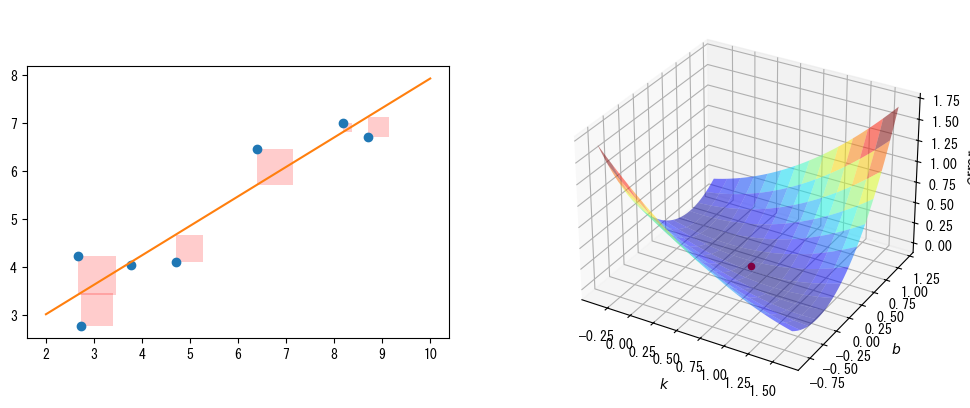

In [5]:
scale_k = 1.0
scale_b = 10.0
scale_error = 1000.0


def S(k, b):
    "直線y=k*x+bと元データX、Yの誤差の二乗和を計算"
    error = np.zeros(k.shape)
    for x, y in zip(X, Y):
        error += (y - (k * x + b)) ** 2
    return error


ks, bs = np.mgrid[k - scale_k : k + scale_k : 40j, b - scale_b : b + scale_b : 40j]
error = S(ks, bs) / scale_error

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(12, 5))

ax1 = plt.subplot(121)

ax1.plot(X, Y, "o")
X0 = np.linspace(2, 10, 3)
Y0 = k * X0 + b
ax1.plot(X0, Y0)

for x, y in zip(X, Y):
    y2 = k * x + b
    rect = Rectangle((x, y), abs(y - y2), y2 - y, facecolor="red", alpha=0.2)
    ax1.add_patch(rect)

ax1.set_aspect("equal")


ax2 = fig.add_subplot(122, projection="3d")

ax2.plot_surface(ks, bs / scale_b, error, rstride=3, cstride=3, cmap="jet", alpha=0.5)
ax2.scatter([k], [b / scale_b], [S(k, b) / scale_error], c="r", s=20)
ax2.set_xlabel("$k$")
ax2.set_ylabel("$b$")
ax2.set_zlabel("$error$");

    
次に、正弦波データをフィッティングする例を見てみましょう：

真のパラメータ: [10, 0.34, 0.5235987755982988]
フィッティングパラメータ [10.25218748  0.3423992   0.50817423]


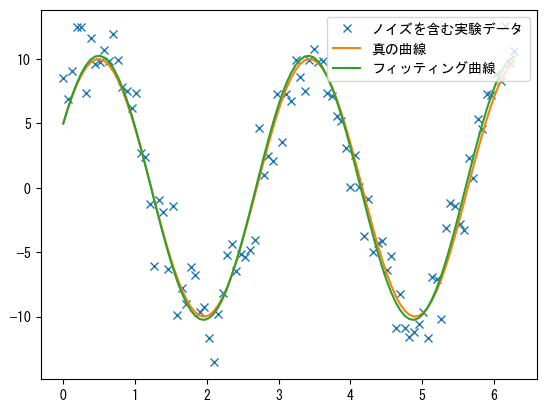

In [6]:
def func(x, p):  #❶
    """
    データフィッティングに使用する関数: A*sin(2*pi*k*x + theta)
    """
    A, k, theta = p
    return A * np.sin(2 * np.pi * k * x + theta)


def residuals(p, y, x):  #❷
    """
    実験データx, yとフィッティング関数の差、pはフィッティングに必要な係数
    """
    return y - func(x, p)


x = np.linspace(0, 2 * np.pi, 100)
A, k, theta = 10, 0.34, np.pi / 6  # 真のデータの関数パラメータ
y0 = func(x, [A, k, theta])  # 真のデータ
# ノイズを加えた実験データ
np.random.seed(0)
y1 = y0 + 2 * np.random.randn(len(x))  #❸

p0 = [7, 0.40, 0]  # 最初の推測値

# leastsqを使用してデータをフィッティング
# residualsは誤差を計算する関数
# p0はフィッティングパラメータの初期値
# argsはフィッティングする実験データ
plsq = optimize.least_squares(residuals, p0, args=(y1, x))  #❹

print("真のパラメータ:", [A, k, theta])
print(
    "フィッティングパラメータ", plsq.x
)  # 実験データをフィッティングした後のパラメータ
plt.plot(x, y1, "x", label="ノイズを含む実験データ")
plt.plot(x, y0, label="真の曲線")
plt.plot(x, func(x, plsq.x), label="フィッティング曲線")
plt.legend(loc="best");

プログラムでは、❶フィッティング対象の関数`func()`は正弦関数で、そのパラメータ`p`は配列で、正弦波の振幅、周波数、位相角に対応する3つのパラメータ`A`、`k`、`theta`を含みます。❸フィッティングする実験データはノイズを含むデータ`(x, y1)`で、配列`y1`は標準正弦波データ`y0`にランダムノイズを加えたものです。

❹`least_squares()`を使用してノイズを含む実験データ`(x, y1)`をフィッティングし、配列`x`と`y0`の間の正弦関係、つまり`A`、`k`、`theta`などのパラメータを決定します。前述の線形フィッティングプログラムとは異なり、ここでは`(y1, x)`を`args`パラメータに渡します。`least_squares()`はこれらの追加パラメータを`residuals()`に渡します。❷したがって、`residuals()`は3つのパラメータを持ち、`p`は正弦関数のパラメータ、`y`と`x`は実験データの配列です。
    
このような1次元曲線フィッティングの場合、`optimize`ライブラリはより使いやすい`curve_fit()`を提供しています。以下は、この関数を使用して正弦波データをフィッティングする例です。この関数の目標関数は`leastsq()`と少し異なり、各最適化パラメータが直接関数のパラメータとして渡されます。

In [7]:
def func2(x, A, k, theta):
    return A * np.sin(2 * np.pi * k * x + theta)


popt, _ = optimize.curve_fit(func2, x, y1, p0=p0)
print(popt)

[10.25218748  0.3423992   0.50817425]


周波数の初期値と真の値の差が大きい場合、フィッティング結果の周波数パラメータは実際の周波数に収束しない可能性があります。以下の例では、周波数の初期値の選択が不適切であったため、`curve_fit()`が真のパラメータに収束しませんでした。この場合、他の方法で周波数の近似値を推定するか、グローバル最適化アルゴリズムを使用することができます。後の例では、グローバル最適化アルゴリズムを使用して正弦波データを再度フィッティングします。

In [8]:
popt, _ = optimize.curve_fit(func2, x, y1, p0=[10, 1, 0])
print("真のパラメータ:", [A, k, theta])
print("フィッティングパラメータ", popt)

真のパラメータ: [10, 0.34, 0.5235987755982988]
フィッティングパラメータ [ 0.71093469  1.02074585 -0.12776742]


## 異常値の影響を軽減する

最小二乗法を使用して曲線をフィッティングする場合、異常値の影響を受けることがあります。これは、最適化の目標関数値が誤差の二乗に比例するためです。フィッティングデータに異常値が含まれている場合、それらの誤差が目標関数値に大きな影響を与え、最適化アルゴリズムはこれらの誤差を減らそうとするため、フィッティングパラメータが真のデータ点から外れることがあります。`least_squares()`の損失関数パラメータ`loss`および補間係数パラメータ`f_scale`を設定することで、誤差と目標関数値の関係を調整し、異常値の影響を軽減することができます。

以下の例では、`func()`は減衰振動関数$f(t) = A e^{-\sigma t} \sin(\omega t)$で、`t`と`y_noise`はフィッティングするデータで、`y_noise`にはランダムノイズといくつかの異常値が含まれています。`curve_fit()`のフィッティング結果は異常値の影響を受けており、真の値から大きく外れていることがわかります。

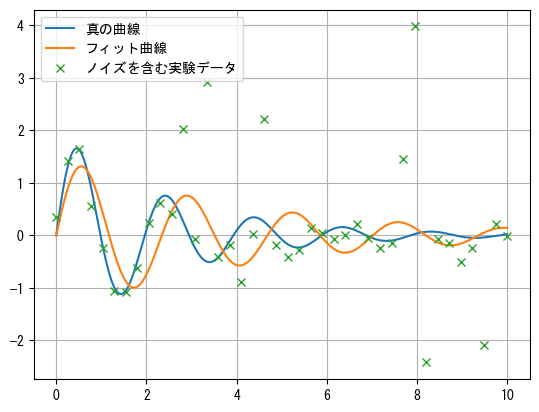

In [9]:
def func(t, A, sigma, omega):
    y = A * np.exp(-sigma * t) * np.sin(omega * t)
    return y


def random_noise(noise, n_outliers, n):
    error = noise * np.random.randn(n)
    outliers = np.random.randint(0, n, n_outliers)
    error[outliers] *= 10
    return error


t = np.linspace(0, 10, 40)
args = 2, 0.4, 3.2
np.random.seed(3)
y_noise = func(t, *args) + random_noise(0.2, 8, len(t))
args_fit, _ = optimize.curve_fit(func, t, y_noise)

t2 = np.linspace(0, 10, 400)
plt.plot(t2, func(t2, *args), label="真の曲線")
plt.plot(t2, func(t2, *args_fit), label="フィット曲線")
plt.plot(t, y_noise, "x", label="ノイズを含む実験データ")
plt.legend()
plt.grid();

`least_squares()`がサポートする損失関数には、linear、soft_l1、huber、cauchy、arctanなどがあります。それらの計算式は以下の通りで、関数のグラフは次のグラフ（左）に示されています。図中の曲線は$\rho(x^2)$を表しています。これらの関数値の増加はlinearよりも緩やかであるため、大きな誤差を持つ外れ値に対して敏感ではありません。

* linear：$\rho(z) = z$，
* soft_l1：$\rho(z) = 2 (\sqrt{1 + z} - 1)$
* huber：$\rho(x)=\begin{cases}
z &{\text{if }}z\leq 1\\
2 \sqrt{z} -1 &{\text{if }} z > 1\\
\end{cases}
$
* cauchy: $\rho(z) =\ln(1 + z)$
* arctan: $\rho(z) = \arctan(z)$

損失関数を使用する場合、`least_squares()`の最適化目標関数は以下のようになります：


$$S(\mathbf{p}) = \sum_{i=1}^m \rho((y_i - f(x_i, \mathbf{p}))^2)$$

損失関数がlinearでない場合、パラメータ`f_scale`を使用して損失関数の補間係数を設定できます。損失関数は以下の式で計算され、$C$は`f_scale`パラメータです。

$$\rho'(e^2) = C^2 \cdot \rho(\frac{e^2}{C^2})$$

次のグラフ（右）は$C$と損失関数の関係を示しています。$C$が0から1の間の場合、損失関数$\rho'$はX軸と$\rho$（図中の黒い破線）の間で変化し、$C$が1より大きい場合、$\rho'$は$\rho$からlinearの損失関数（図中の黒い実線）の間で変化します。

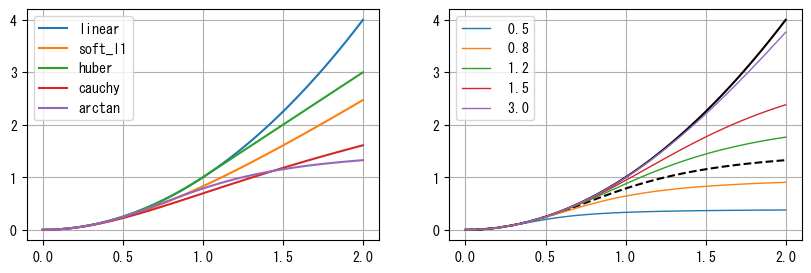

In [10]:
def linear(z):
    return z


def soft_l1(z):
    return 2 * ((1 + z) ** 0.5 - 1)


def huber(z):
    return np.where(z <= 1, z, 2 * z**0.5 - 1)


def cauchy(z):
    return np.log(1 + z)


def arctan(z):
    return np.arctan(z)


fig, axes = plt.subplots(1, 2, figsize=(10, 3))
z = np.linspace(0, 2, 100)
for _func in (linear, soft_l1, huber, cauchy, arctan):
    y = _func(z**2)
    axes[0].plot(z, y, label=_func.__name__)
axes[0].legend()


def f_scale(func, z, c):
    return c**2 * func(z**2 / c**2)


axes[1].plot(z, z**2, "k")
axes[1].plot(z, arctan(z**2), "k--")
for c in (0.5, 0.8, 1.2, 1.5, 3.0):
    axes[1].plot(z, f_scale(arctan, z, c), label="{:4.1f}".format(c), linewidth=1)
axes[1].legend()

for ax in axes:
    ax.grid(True);

以下では、`f_scale`を0.3に設定した`soft_l1`を損失関数としてデータをフィットします。フィット曲線が真の曲線に非常に近いことがわかります。

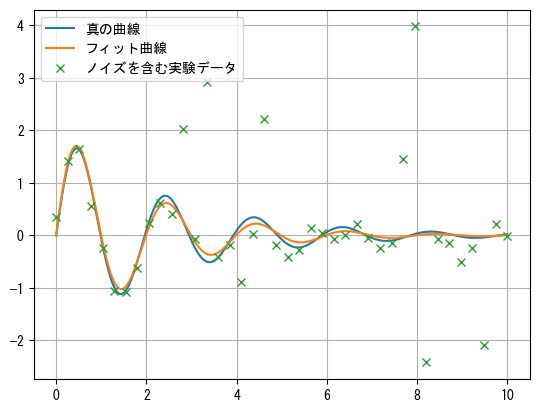

In [11]:
def err(pars):
    return func(t, *pars) - y_noise


res = optimize.least_squares(err, [1, 1, 1], loss="soft_l1", f_scale=0.3)

plt.plot(t2, func(t2, *args), label="真の曲線")
plt.plot(t2, func(t2, *res.x), label="フィット曲線")
plt.plot(t, y_noise, "x", label="ノイズを含む実験データ")
plt.legend()
plt.grid();

## 関数の局所最小値の計算

`optimize`ライブラリは、関数の最小値を求めるための多くのアルゴリズムを提供しています：Nelder-Mead、Powell、CG、BFGS、Newton-CG、L-BFGS-Bなど。以下では、これらの最適化関数がどのように関数の最小値を見つけるかを観察するための例を示します。この例では、最小値を計算する関数$f(x,y)$は以下の通りです：

$$f(x,y) = (1-x)^2 + 100(y-x^2)^2$$

この関数はRosenbrock関数と呼ばれ、最小化アルゴリズムの収束速度をテストするためによく使用されます。この関数は非常に平坦な谷の領域を持ち、この谷の領域に収束するのは比較的簡単ですが、谷の領域内で最小点を見つけるのは困難です。関数の計算式から、この関数の最小値は0で、(1, 1)にあることがわかります。
    
計算速度と精度を向上させるために、いくつかのアルゴリズムには`fprime`パラメータがあります。これは、目的関数$f()$の各変数に対する偏導関数を計算する関数です。$f(x,y)$の変数$x$と$y$に対する偏導関数は以下の通りです：

$$\frac{\partial f}{\partial x}= -2 + 2x - 400x(y-x^2)$$
$$\frac{\partial f}{\partial y}= 200y - 200x^2$$

一方、Newton-CGアルゴリズムはヘッセ行列を計算する必要があります。これは、独立変数をベクトルとする実数値関数の二次偏導関数からなる正方行列です。関数$f(x_1, x_2, \dots, x_n)$のヘッセ行列は以下のように定義されます：

$$\begin{bmatrix} 
\frac{\partial^2 f}{\partial x_1^2} & 
\frac{\partial^2 f}{\partial x_1 \partial x_2} &
\cdots & 
\frac{\partial^2 f}{\partial x_1 \partial x_n} \\ 
\frac{\partial^2 f}{\partial x_2 \partial x_1} &
\frac{\partial^2 f}{\partial x_2^2} &
\cdots &
\frac{\partial^2 f}{\partial x_2 \partial x_n} \\
\vdots &
\vdots &
\ddots &
\vdots \\
\frac{\partial^2 f}{\partial x_n \partial x_1} &
\frac{\partial^2 f}{\partial x_n \partial x_2} &
\cdots &
\frac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}$$

この例では、ヘッセ行列は2次行列です：

$$\begin{bmatrix} 2(600x^2 - 200 y + 1) & -400x \\
                  -400x & 200 \end{bmatrix}$$

以下では、さまざまな最小値最適化アルゴリズムを使用して$f(x,y)$の最小値を計算します。その出力から、いくつかのアルゴリズムは収束に時間がかかりますが、他のアルゴリズムは導関数情報を利用して最小点をより速く見つけることがわかります。

In [12]:
import warnings

warnings.filterwarnings("ignore")

In [13]:
def target_function(x, y):
    return (1 - x) ** 2 + 100 * (y - x**2) ** 2


class TargetFunction(object):

    def __init__(self):
        self.f_points = []
        self.fprime_points = []
        self.fhess_points = []

    def f(self, p):
        x, y = p.tolist()
        z = target_function(x, y)
        self.f_points.append((x, y))
        return z

    def fprime(self, p):
        x, y = p.tolist()
        self.fprime_points.append((x, y))
        dx = -2 + 2 * x - 400 * x * (y - x**2)
        dy = 200 * y - 200 * x**2
        return np.array([dx, dy])

    def fhess(self, p):
        x, y = p.tolist()
        self.fhess_points.append((x, y))
        return np.array([[2 * (600 * x**2 - 200 * y + 1), -400 * x], [-400 * x, 200]])


def fmin_demo(method):
    target = TargetFunction()
    init_point = (-1, -1)
    res = optimize.minimize(
        target.f,
        init_point,
        method=method,
        jac=target.fprime,
        hess=target.fhess,
    )
    return res, [
        np.array(points)
        for points in (target.f_points, target.fprime_points, target.fhess_points)
    ]


methods = ("Nelder-Mead", "Powell", "CG", "BFGS", "Newton-CG", "L-BFGS-B")
for method in methods:
    res, (f_points, fprime_points, fhess_points) = fmin_demo(method)
    print(
        f"{method:12s}: min={res['fun']:12g}, "
        f"f count={len(f_points):3d}, "
        f"fprime count={len(fprime_points):3d}, "
        f"fhess count={len(fhess_points):3d}"
    )

Nelder-Mead : min= 5.30934e-10, f count=125, fprime count=  0, fhess count=  0
Powell      : min=           0, f count= 47, fprime count=  0, fhess count=  0
CG          : min= 9.61938e-21, f count= 39, fprime count= 39, fhess count=  0
BFGS        : min= 1.84992e-16, f count= 40, fprime count= 40, fhess count=  0
Newton-CG   : min= 5.22666e-10, f count= 60, fprime count= 60, fhess count= 38
L-BFGS-B    : min=  6.5215e-15, f count= 33, fprime count= 33, fhess count=  0


次のグラフは、さまざまな最適化アルゴリズムの探索パスを示しています。図中の円点は`f()`が呼び出されたときの座標点を表し、円点の色は呼び出し順序を示します。また、×点は`fprime()`が呼び出されたときの座標点を表します。図中の画像は二次元関数の値を表しており、値が大きいほど色が薄く、値が小さいほど色が濃くなります。関数の谷の領域をより明確に表示するために、図中に表示されているのは、対数関数`log10()`で$f(x,y)$を処理した結果です。

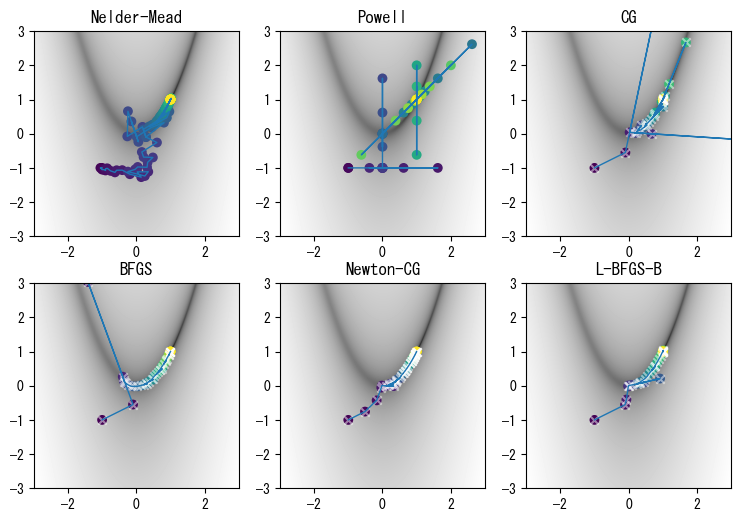

In [14]:
def draw_fmin_demo(f_points, fprime_points, ax):
    xmin, xmax = -3, 3
    ymin, ymax = -3, 3
    Y, X = np.ogrid[ymin:ymax:500j, xmin:xmax:500j]
    Z = np.log10(target_function(X, Y))
    zmin, zmax = np.min(Z), np.max(Z)
    ax.imshow(
        Z, extent=(xmin, xmax, ymin, ymax), origin="lower", aspect="auto", cmap="gray"
    )
    ax.plot(f_points[:, 0], f_points[:, 1], lw=1)
    ax.scatter(
        f_points[:, 0], f_points[:, 1], c=range(len(f_points)), s=50, linewidths=0
    )
    if len(fprime_points):
        ax.scatter(
            fprime_points[:, 0], fprime_points[:, 1], marker="x", color="w", alpha=0.5
        )
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)


import matplotlib as mpl

with mpl.rc_context({"font.size": 10.0}):
    fig, axes = plt.subplots(2, 3, figsize=(9, 6))
    methods = ("Nelder-Mead", "Powell", "CG", "BFGS", "Newton-CG", "L-BFGS-B")
    for ax, method in zip(axes.ravel(), methods):
        res, (f_points, fprime_points, fhess_points) = fmin_demo(method)
        draw_fmin_demo(f_points, fprime_points, ax)
        ax.set_aspect("equal")
        ax.set_title(method)

## 全域最小値の計算

前述のいくつかの最小値最適化アルゴリズムは、局所的な最小値しか計算できません。`optimize`ライブラリは、グローバルな最適化を行うためのいくつかのアルゴリズムも提供しています。以下では、前述の正弦波フィッティングを例として、グローバル最適化関数の使用方法を示します。`least_squares()`を使用して正弦波をフィットする場合、誤差関数`residuals()`は、各サンプル点の誤差を表す配列を返します。一方、関数最小値アルゴリズムはスカラー値のみを最小化できるため、最小化の目標関数`func_error()`はすべてのサンプル点の誤差の二乗和を返します。

In [15]:
def func(x, p):
    A, k, theta = p
    return A * np.sin(2 * np.pi * k * x + theta)


def func_error(p, y, x):
    return np.sum((y - func(x, p)) ** 2)


x = np.linspace(0, 2 * np.pi, 100)
A, k, theta = 10, 0.34, np.pi / 6
y0 = func(x, [A, k, theta])
np.random.seed(0)
y1 = y0 + 2 * np.random.randn(len(x))

`optimize.basinhopping()`グローバル最適化関数を使用して、正弦波の3つのパラメータを見つけます。最初の2つのパラメータは、他の最小値関数と同様に、目的関数と初期値です。これはグローバル最適化関数であるため、初期値の選択はそれほど重要ではありません。`niter`パラメータはグローバル最適化アルゴリズムの反復回数で、反復回数が多いほど、グローバルな最適解を見つける可能性が高くなります。

`basinhopping()`内部では局所最小値関数を呼び出す必要があり、その`minimizer_kwargs`パラメータは、使用する局所最小値アルゴリズムとその関数に渡すパラメータを決定します。以下のプログラムでは、L-BFGS-Bアルゴリズムを使用して局所最小値を探索し、2つのオブジェクト`y1`と`x`をこの局所最小値求解関数の`args`パラメータとして渡します。この関数は、これらのパラメータを`func_error()`に渡します。

In [16]:
result = optimize.basinhopping(
    func_error,
    (1, 1, 1),
    niter=10,
    minimizer_kwargs={"method": "L-BFGS-B", "args": (y1, x)},
)
print(result.x)

[10.25218689 -0.34239909  2.63341581]


位相は元の係数とは異なりますが、正弦関数の周期性により、フィット曲線は元のデータと一致します。次のグラフに示されています。

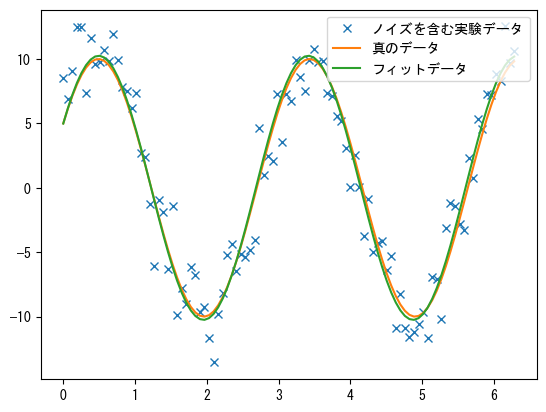

In [17]:
plt.plot(x, y1, "x", label="ノイズを含む実験データ")
plt.plot(x, y0, label="真のデータ")
plt.plot(x, func(x, result.x), label="フィットデータ")
plt.legend(loc="best");

## 応用実例

### 区分関数のフィッティング

このセクションでは、最小化アルゴリズムを使用して、データポイントを一連の折れ線でフィッティングする方法を紹介します。計算性能が限られた組み込みシステムでは、複雑な関数曲線を計算するために折れ線近似がよく使用されます。$N$セグメントからなる折れ線は$N+1$個の点を持ち、各点のX軸とY軸座標を決定する必要があるため、この折れ線を決定するには$2(N+1)$個のパラメータが必要です。

$N+1$個の座標点のX軸座標が増加することを保証するために、以下の`segments_fit()`では、❶$N$個の線分のX軸上の長さを折れ線のX軸パラメータとして使用し、$N+1$個の点のY軸座標を折れ線のY軸パラメータとして使用します。最初の点のX軸座標は、データポイントのX軸座標の最小値に固定することができます。❷`bounds`にはすべてのパラメータの範囲が保存されます。最初の$N$個のパラメータは0より大きく、データポイントのX軸座標の範囲より小さくなければなりません。後の$N+1$個のパラメータは`(None, None)`を使用して範囲制限がないことを示します。❸`func()`は、折れ線上の$N+1$個の点のX軸座標とY軸座標をそれぞれ表す2つの配列を返します。❹`error()`は、折れ線とデータポイント間の誤差を返します。誤差の第一項は、データポイントと折れ線のY軸座標の差の二乗平均であり、第二項は、折れ線のX軸の範囲とデータポイントのX軸の範囲の差の二乗値です。これにより、折れ線の最後の点のX座標がデータポイントのX軸座標の最大値に正確に位置することが保証されます。

In [18]:
def segments_fit(xdata, ydata, n):
    xmin = xdata.min()
    xmax = xdata.max()
    xspan = xmax - xmin

    segments_init = np.full(n, (xmax - xmin) / n)
    y_init = np.zeros(n + 1)
    init = np.r_[segments_init, y_init]  #❶
    bounds = [(0, xmax - xmin)] * len(segments_init) + [(None, None)] * len(y_init)  #❷

    def func(p):  #❸
        segments = p[:n]
        y = p[n:]
        x = np.r_[xmin, segments].cumsum()
        return x, y

    def error(p):  #❹
        x, y = func(p)
        yfit = np.interp(xdata, x, y)
        return np.mean((yfit - ydata) ** 2) + ((x[-1] - x[0]) - xspan) ** 2

    r = optimize.minimize(error, x0=init, method="L-BFGS-B", bounds=bounds)
    return func(r.x)

以下では、`segments_fit()`を使用して、`make_test_data()`が生成する折れ線データポイントと正弦波にノイズを加えたデータポイントをそれぞれフィッティングし、その結果を次のグラフに示します。

In [19]:
def make_test_data(seg_count, point_count):
    x = np.random.uniform(2, 10, seg_count)
    x = np.cumsum(x)
    x *= 10 / x.max()
    y = np.cumsum(np.random.uniform(-1, 1, seg_count))
    X = np.random.uniform(0, 10, point_count)
    Y = np.interp(X, x, y) + np.random.normal(0, 0.05, point_count)
    return X, Y


x1, y1 = make_test_data(10, 1000)
x2 = np.random.uniform(0, 2 * np.pi, 1000)
y2 = np.sin(x2) + np.random.normal(0, 0.05, x2.shape)

sx1, sy1 = segments_fit(x1, y1, 10)
sx2, sy2 = segments_fit(x2, y2, 10)

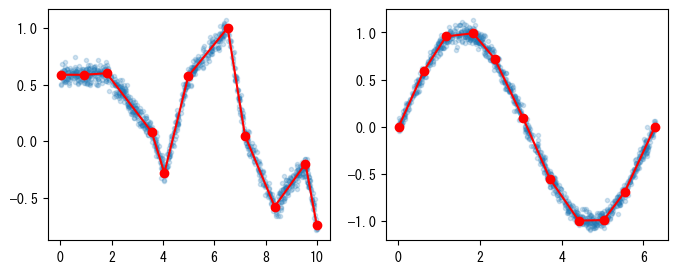

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(x1, y1, ".", alpha=0.2)
axes[0].plot(sx1, sy1, "-or")
axes[1].plot(x2, y2, ".", alpha=0.2)
axes[1].plot(sx2, sy2, "-or");

### エネルギー最小値による懸垂線の計算

この節では、最適化アルゴリズムを使用して懸垂線の位置エネルギーを最小化し、懸垂線の形状を計算する方法を紹介します。ロープの両端を同じ高さに固定し、重力によって垂れ下がる形状を懸垂線と呼び、その曲線関数は以下の通りです：

$$y = a\cosh \frac{x}{a}$$
 
ここで、$a$は垂れ下がりの程度を決定する係数です。以下の`catenary()`は懸垂線の方程式を座標変換し、それが(0, 0)と(1, 0)の2点を通るようにします。その効果は次のグラフに示されています：

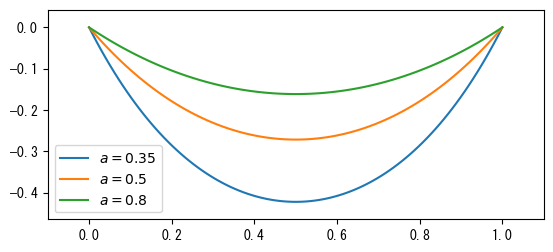

In [21]:
def catenary(x, a):
    return a * np.cosh((x - 0.5) / a) - a * np.cosh((-0.5) / a)


x = np.linspace(0, 1, 100)
for a in [0.35, 0.5, 0.8]:
    plt.plot(x, catenary(x, a), label="$a={:g}$".format(a))
ax = plt.gca()
ax.set_aspect("equal")
ax.legend(loc="best")
plt.margins(0.1)

曲線の長さは以下の定積分を使用して計算できます：

$$s = \int_{0}^{1} \sqrt { 1 + (\frac{dy}{dx})^2 } dx$$

以下では、前述の`catenary()`を使用して$a=0.35$の場合の曲線の長さを計算します：

In [22]:
y = catenary(x, 0.35)
length = np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2).sum()
length

1.3765522648842718

最適化アルゴリズムを使用して懸垂線を計算するために、懸垂線を複数のリンクで接続された質点系と見なすことができます。質点間が剛体接続されている場合、リンクは弾性位置エネルギーを蓄えず、重力によってシステム全体の重力位置エネルギーが最低になります。したがって、位置エネルギーを最小化することで各質点の最終状態を計算できます。懸垂線の両端が固定されており、質点間の距離が固定されているため、この最小化問題には多くの制約条件があります。制約条件を最小限にするために、各リンクの角度を変数として懸垂線の状態を表します。懸垂線の一端は`(0, 0)`に固定され、各リンクを経て座標`(1, 0)`に到達します。したがって、以下の2つの制約条件を満たす必要があります。ここで、$\theta_i$は各リンクの方向、$l$はリンクの長さです。システム全体は次のグラフに示されています。

$$\sum{l \cos{\theta_i}} = 1, \sum{l \sin{\theta_i}} = 0$$

第$i$質点のY軸位置は以下の通りです：

$$y_i = \sum_{k=0}^{i}{l \sin{\theta_k}}$$

位置エネルギー$P$は以下の式で表されます：

$$P = \sum{y_i}$$

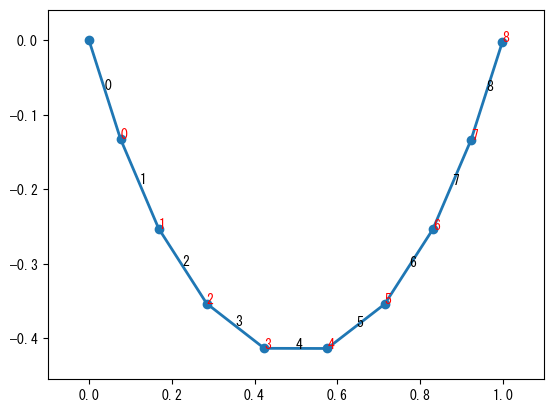

In [23]:
x = np.linspace(0, 1, 1000)
y = catenary(x, 0.35)
s = np.cumsum(np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2))
p = np.linspace(0, s[-1], 10)
idx = np.searchsorted(s, p)
x, y = x[idx], y[idx]
plt.plot(x, y, "-o", lw=2)
for i, (x1, x2, y1, y2) in enumerate(zip(x[:-1], x[1:], y[:-1], y[1:])):
    plt.text((x1 + x2) * 0.5, (y1 + y2) * 0.5, "%d" % i)
    plt.text(x2, y2, "%d" % i, color="r", fontsize=10)
plt.margins(0.1);

したがって、最小化問題は、2つの制約条件を満たし、$P$を最小化する$\theta_i$の組を見つけることです。$\theta_i$の範囲は$\frac{-\pi}{2} < \theta_i < \frac{\pi}{2}$です。このような等式制約条件付き最小化問題は、`SLSQP`アルゴリズムを使用して解くことができます。

以下のプログラムでは、`g1()`と`g2()`はそれぞれ最右端の点のX座標とY座標が満たすべき条件を計算します。これらの関数が0を返すとき、制約条件が満たされていることを示します。`P(theta)`は状態`theta`の位置エネルギーを計算します。❶最適化の計算速度を向上させるために、初期値が2つの制約条件を満たすようにします。これは次のグラフの×印で示されています。❷`constraints`パラメータは制約条件のリストです。`minimize()`のドキュメントによると、最適化アルゴリズムが`SLSQP`の場合、各制約条件は辞書オブジェクトで指定されます。キー`type`が`'eq'`の場合、等式制約を表し、`'ineq'`の場合、不等式制約を表します。キー`fun`は制約条件を計算する関数です。❸パラメータ`bounds`を使用して、各変数の範囲を指定します。

In [24]:
N = 30

l = length / N


def g1(theta):
    return np.sum(l * np.cos(theta)) - 1.0


def g2(theta):
    return np.sum(l * np.sin(theta)) - 0.0


def P(theta):
    y = l * np.sin(theta)
    cy = np.cumsum(y)
    return np.sum(cy)


theta0 = np.arccos(1.0 / length)
theta_init = [-theta0] * (N // 2) + [theta0] * (N // 2)  #❶

res = optimize.minimize(
    P,
    theta_init,
    method="SLSQP",
    constraints=[dict(type="eq", fun=g1), dict(type="eq", fun=g2)],  #❷
    bounds=[(-np.pi / 2, np.pi / 2)] * N,  #❸
)
print(res.message, "nit =", res.nit)

Optimization terminated successfully nit = 9


9回の反復で最適解が見つかったことがわかります。以下では、$\theta_i$に基づいて各質点の位置を計算し、次のグラフに示します。図中の青い曲線は懸垂線方程式による理論値です。

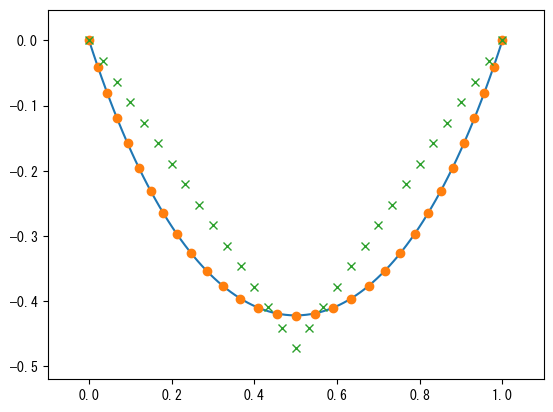

In [25]:
x_init = np.r_[0, np.cumsum(l * np.cos(theta_init))]
y_init = np.r_[0, np.cumsum(l * np.sin(theta_init))]

theta = res.x
x = np.r_[0, np.cumsum(l * np.cos(theta))]
y = np.r_[0, np.cumsum(l * np.sin(theta))]
x2 = np.linspace(0, 1, 100)
y2 = catenary(x2, 0.35)

plt.plot(x2, y2)
plt.plot(x, y, "o")
plt.plot(x_init, y_init, "x")
plt.margins(0.1)

### 最速降線の計算

最速降線問題とは、2点間に摩擦のない軌道を設置し、小球が高点から低点まで移動するのに最短時間を要する曲線を求める問題です。2点の高さが同じ極端な場合を考えると、この曲線は直線ではないことが明らかです。Wikipediaの関連情報によると、下降高さが$D$の最速降線は以下の微分方程式を満たします：

$$dx=\sqrt{\frac{y}{D-y}}dy$$

最適化アルゴリズムを使用して最速降線を近似計算することができます。まず、X軸を0から`target`まで`N-1`等分し、各点に対応するY軸座標$y_i$を最適化の変数とします。最適化の目標は、小球がこの曲線を通過するのに要する時間を計算することです。エネルギー保存の法則により、小球が座標点に到達する速度は$v = \sqrt{2 g y_i}$と計算できます。

小球が各線分を通過する速度は、2つの端点の速度の平均値として計算し、線分の長さは2つの端点の距離に基づいて計算します。これにより、小球が各線分を通過する時間を求めることができます。最適化の目標は、これらの時間の合計が最小になること、つまり小球が曲線全体を通過する時間が最短になることです。

以下は、最適化アルゴリズムを使用して最速降線を計算するプログラムです。計算結果は次のグラフに示されています。

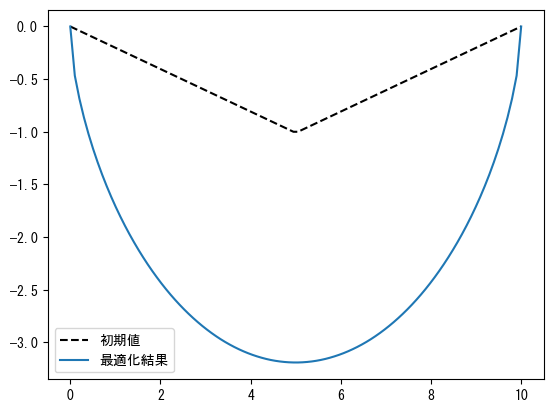

In [26]:
N = 100
target = 10.0
x = np.linspace(0, target, N)
tmp = np.linspace(0, -1, N // 2)
y0 = np.r_[tmp, tmp[::-1]]
g = 9.8


def total_time(y):
    s = np.hypot(np.diff(x), np.diff(y))  #❶
    v = np.sqrt(2 * g * np.abs(y))  #❷
    avg_v = np.maximum((v[1:] + v[:-1]) * 0.5, 1e-10)  #❸
    t = s / avg_v
    return t.sum()


def fix_two_ends(y):
    return y[[0, -1]]


res = optimize.minimize(
    total_time, y0, method="SLSQP", constraints=[dict(type="eq", fun=fix_two_ends)]
)  #❹
y_opt = res.x

plt.plot(x, y0, "k--", label="初期値")
plt.plot(x, y_opt, label="最適化結果")
plt.legend(loc="best");

❶`hypot()`を呼び出して各線分の長さを計算し、❷エネルギー保存の公式を使用して小球が各点に到達する速度を計算し、❸小球が各線分を通過する平均速度を計算します。平均速度が0になることで時間が計算できなくなるのを防ぐため、`maximum()`を使用して速度の下限を$10^{-10}$に設定しています。

❹曲線の両端のY軸座標を0に保つ必要があるため、`SLSQP`最適化アルゴリズムを使用し、等式制約条件`fix_two_end()`を使用して両端のY軸座標が常に0になるようにします。